# Preprocessing - Experiments

- loading the required information from the json files
- preprocessing
- extracting key phrases

## Requirements

- nltk
- python-rake

In [37]:
%%capture
!pip install python-rake
!pip install git+https://github.com/boudinfl/pke.git

!python -m nltk.downloader stopwords
!python -m nltk.downloader universal_tagset
!python -m spacy download en # download the english model

In [86]:
from __future__ import print_function

import string
import random

import json
import os
from os import getcwd, pardir
from os import listdir
from os.path import isfile, join
from glob import glob

from utils.literature import DataLoader, get_full_text, get_document_title, get_files

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

import RAKE
from pke.unsupervised import TopicRank, MultipartiteRank, TextRank, TopicalPageRank, PositionRank, SingleRank

## Getting the test files

In [2]:
root_dir = join(pardir, 'dataset')
files = get_files(root_dir)

In [6]:
num_files = 10

In [34]:
def load_text(file):
    dl = DataLoader(f)
    text = dl.get_full_text()
    return text

In [36]:
texts = [load_text(f) for f in files[:num_files]]
print(len(texts))

10


## Rapid Automatic Keyword Extraction - RAKE

In [27]:
rake = RAKE.Rake(RAKE.SmartStopList())

In [37]:
def rake_func():
    for text in texts:
        keyphrases = rake.run(text, minCharacters = 5, maxWords = 3, minFrequency = 10)

rake_time = %timeit -o rake_func()

465 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Text Rank

In [83]:
from IPython.utils.io import capture_output

In [93]:
pos = {'NOUN', 'PROPN', 'ADJ'}

In [94]:
def text_rank_func():
    for text in texts:
        extractor = TextRank()
        extractor.load_document(input=text, language='en')
        extractor.candidate_weighting(window=2,pos=pos, top_percent=0.33)
        keyphrases = extractor.get_n_best(n=10)

text_rank_time = %timeit -o text_rank_func()

5.41 s ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Single Rank

In [85]:
pos = {'NOUN', 'PROPN', 'ADJ'}

In [89]:
def single_rank_func():
    for text in texts:
        extractor = SingleRank()
        extractor.load_document(input=text, language='en')
        extractor.candidate_selection(pos=pos)
        extractor.candidate_weighting(window=10,pos=pos)
        keyphrases = extractor.get_n_best(n=10)

single_rank_time = %timeit -o single_rank_func()

5.64 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Topic Rank

In [38]:
def topic_rank_func():
    for text in texts:
        extractor = TopicRank()
        extractor.load_document(input=text, language='en')
        extractor.candidate_selection()
        extractor.candidate_weighting()
        keyphrases = extractor.get_n_best(n=10)

topic_rank_time = %timeit -o topic_rank_func()

12.1 s ± 669 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Topical Page Rank --> Requires lda_model

## Position Rank

In [92]:
pos = {'NOUN', 'PROPN', 'ADJ'}
grammar = "NP: {<ADJ>*<NOUN|PROPN>+}"

In [91]:
def position_rank_func():
    for text in texts:
        extractor = PositionRank()
        extractor.load_document(input=text, language='en')
        extractor.candidate_selection(grammar=grammar, maximum_word_number=3)
        extractor.candidate_weighting(window=10,pos=pos)
        keyphrases = extractor.get_n_best(n=10)

position_rank_time = %timeit -o position_rank_func()

6.67 s ± 515 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multipartite Rank

In [39]:
pos = {'NOUN', 'PROPN', 'ADJ'}
stoplist = list(string.punctuation)
stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
stoplist += stopwords.words('english')

In [41]:
def multipartite_rank_func():
    for text in texts:
        extractor = MultipartiteRank()
        extractor.load_document(
            input=text, 
            language='en',
            normalization='stemming')

        extractor.candidate_selection(pos=pos, stoplist=stoplist)
        extractor.candidate_weighting(alpha=1.1,
                                threshold=0.74,
                                method='average')

        keyphrases = extractor.get_n_best(n=10)

multipartite_rank_time = %timeit -o multipartite_rank_func()

20.5 s ± 855 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
import pandas as pd

In [63]:
df = pd.DataFrame()
df['names'] = ['RAKE', 'Text Rank', 'Single Rank', 'Topic Rank', 'Position Rank','Multipartite Rank']

df['mean execution time'] = [
    rake_time.average/num_files, text_rank_time.average/num_files ,single_rank_time.average/num_files, 
    topic_rank_time.average/num_files, position_rank_time.average/num_files multipartite_rank_time.average/num_files]

df['stddev'] = [
    rake_time.stdev/num_files, text_rank_time.stdev/num_files, single_rank_time.average/stdev, 
    topic_rank_time.stdev/num_files, position_rank_time.stdev/num_files, multipartite_rank_time.stdev/num_files]

Text(0, 0.5, 'time in s')

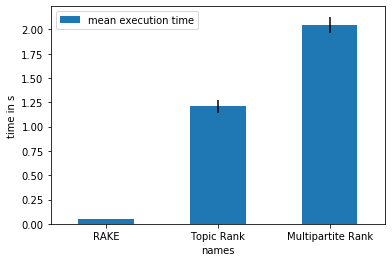

In [71]:
axes = df.plot.bar(x='names', y='mean execution time', yerr='stddev', rot=0)
axes.set_ylabel("time in s")